# Imports

In [1]:
import os
import numpy as np
import random
import pandas as pd
from matplotlib import pyplot as plt
import math
import operator
import copy
import csv
import pickle

from torch_sparse import SparseTensor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

import open3d as o3d
from open3d import *

import nibabel as nib
from skimage.measure import marching_cubes 
import pyvista

import trimesh
import rtree
from trimesh import viewer
from trimesh.viewer import windowed
import pyglet
import glooey

import vtk

# Paths

In [15]:
local_data_path = "../../local_data/"
segmentations_path = "../../local_data/organ_segmentations"
original_meshes_path = os.path.join(local_data_path, "original_meshes/")
decimated_path = os.path.join(local_data_path, "decimations/")
only_reg_path = os.path.join(local_data_path, "registered_only/")
trimesh_reg_path = os.path.join(local_data_path, "trimesh_registrations/")
registration_transformations_path = os.path.join(local_data_path, "registration_transformations/")
combined_meshes_path = os.path.join(local_data_path, "combined_meshes/")
combined_pcds_path = os.path.join(local_data_path, "combined_pcds/")
manual_average_pcds_path = os.path.join(local_data_path, "manual_average_pcds/")  
manual_median_pcds_path = os.path.join(local_data_path, "manual_median_pcds/")  
manual_average_meshes_path = os.path.join(local_data_path, "manual_average_meshes/")  
manual_median_meshes_path = os.path.join(local_data_path, "manual_median_meshes/")  
average_meshes_path = os.path.join(local_data_path, "average_meshes/")  
average_downsampled_meshes_path = os.path.join(local_data_path, "average_meshes/downsample/")  
vtk_mesh_atlas_path = os.path.join(local_data_path, "vtk_mesh_atlas/")
unbiased_mesh_atlas_path = os.path.join(local_data_path, "unbiased_mesh_atlas/")
test_output_paths = os.path.join(local_data_path, "tests/")  

organs = ["liver_mesh.ply", "spleen_mesh.ply", "left_kidney_mesh.ply", "right_kidney_mesh.ply", "pancreas_mesh.ply"]

In [16]:
female_path = "../data/female_mesh_ids.csv"
male_path = "../data/male_mesh_ids.csv"

with open(female_path, newline='') as csvfile:
    female_ids = list(csv.reader(csvfile, delimiter=","))
    female_ids = np.asarray(female_ids)
    female_ids = female_ids.flatten()

with open(male_path, newline='') as csvfile:
    male_ids = list(csv.reader(csvfile, delimiter=","))
    male_ids = np.asarray(male_ids)
    male_ids = male_ids.flatten()
    
gender_dict = {"female": female_ids, "male": male_ids}

# Functions

## Visualizations

In [35]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud], mesh_show_wireframe=True, mesh_show_back_face=True, window_name="Outliers in Red")
    
############################################################################################

def compare_all_subjects(gender, registered):
    assert gender in ["male", "female"]
    
    if(registered):
        path = os.path.join(trimesh_reg_path, gender)
        # path = os.path.join(only_reg_path, gender)
        # path = "../../local_data/server_test/registered_meshes/"
    else:
        # path = os.path.join(decimated_path, gender)
        path = os.path.join(original_meshes_path)
        
    dirs = next(os.walk(path))[1]
        
    for i in range(0, len(organs)):
        meshes = []
        for dir in dirs:
            mesh = io.read_triangle_mesh(os.path.join(path, (str(dir) + "/"), organs[i]))
            mesh.paint_uniform_color([random.random(), random.random(), random.random()])
            meshes.append(mesh)
        o3d.visualization.draw_geometries(meshes, mesh_show_wireframe=True, mesh_show_back_face=True, window_name=organs[i])
    
############################################################################################
    
def compare_results(source, target, translation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.translate(translation)
    o3d.visualization.draw_geometries([source_temp, target_temp], mesh_show_wireframe=True, mesh_show_back_face=True, window_name="Original in Red")
    
############################################################################################
    
def compare_organ(gender, organ, average = True):
    assert organ in organs
    
    path = os.path.join(only_reg_path, gender)
    dirs = next(os.walk(path))[1]
    meshes = []
    source_added = False
    result_path = unbiased_mesh_atlas_path
    
#     if(manual):
#         # source = io.read_triangle_mesh(os.path.join(average_downsampled_meshes_path, gender, organ))
#         source = io.read_triangle_mesh(os.path.join(manual_average_meshes_path, gender, organ))
#     else:
#         source = io.read_triangle_mesh(os.path.join(average_meshes_path, gender, organ))
    
#     for i, dir in enumerate(dirs):
#         if(manual):
#             target = io.read_triangle_mesh(os.path.join(trimesh_reg_path, gender, str(dir), organ))           
#         else:
#             target = io.read_triangle_mesh(os.path.join(trimesh_reg_path, gender, str(dir), organ))
    if(average):
        # source = io.read_triangle_mesh(os.path.join(average_downsampled_meshes_path, gender, organ))
        source = io.read_triangle_mesh(os.path.join(result_path, gender, "avg", organ))
    else:
        source = io.read_triangle_mesh(os.path.join(result_path, gender, "median", organ))
    
    for i, dir in enumerate(dirs):
        target = io.read_triangle_mesh(os.path.join(only_reg_path, gender, str(dir), organ))
    
        if(i > ((len(dirs) / 2)) and not source_added):
            source_added = True
            source.paint_uniform_color([1, 0, 0])
            meshes.append(source)
            
        target.paint_uniform_color([0, 0.651, 0.929])
        meshes.append(target)
        
    for i, mesh in enumerate(meshes):
        x = (i % 3)/2
        y = (int(i / 3))/2
        mesh.translate((x + 0.01, y + 0.01, 0.01))
        
    o3d.visualization.draw_geometries(meshes, mesh_show_wireframe=True, mesh_show_back_face=True, window_name="Average in Red")
    
############################################################################################
    
def create_trimesh_window(mesh):
    window = windowed.SceneViewer(mesh.scene(),
                              start_loop=False)

    gui = glooey.Gui(window)
    pyglet.app.run()
    
############################################################################################

## Mesh Creation

In [18]:
#Reading and Loading
def pad_edge_list(edges):
    padding = np.ones(edges.shape[0], int)*3
    edges_w_padding = np.vstack((padding, edges.T)).T
    return edges_w_padding
    
############################################################################################

#load organ meshes data
def load_meshes(segmentations_path = "../../local_data/organ_segmentations/", patient_id = 1000071):
    abdominal_segmentations = nib.load(os.path.join(segmentations_path, str(patient_id), "prd.nii.gz"))
    abdominal_segmentations_data = abdominal_segmentations.get_fdata()
    
    #1:Liver 2:Spleen 3:Left Kidney 4:Right Kidney 5:Pancreas 
    verts1, faces1, norms1, vals1 = marching_cubes(abdominal_segmentations_data==1, level=0, step_size=1)
    verts2, faces2, norms2, vals2 = marching_cubes(abdominal_segmentations_data==2, level=0, step_size=1)
    verts3, faces3, norms3, vals3 = marching_cubes(abdominal_segmentations_data==3, level=0, step_size=1)
    verts4, faces4, norms4, vals4 = marching_cubes(abdominal_segmentations_data==4, level=0, step_size=1)
    verts5, faces5, norms5, vals5 = marching_cubes(abdominal_segmentations_data==5, level=0, step_size=1)
    verts1 = verts1/np.array(abdominal_segmentations_data.shape) 
    verts2 = verts2/np.array(abdominal_segmentations_data.shape) 
    verts3 = verts3/np.array(abdominal_segmentations_data.shape) 
    verts4 = verts4/np.array(abdominal_segmentations_data.shape) # to normalize ponit coordinate in [0,1]
    verts5 = verts5/np.array(abdominal_segmentations_data.shape) # to normalize ponit coordinate in [0,1]
    edges1 = np.concatenate((faces1[:,:2], faces1[:,1:]), axis=0)
    edges2 = np.concatenate((faces2[:,:2], faces2[:,1:]), axis=0)
    edges3 = np.concatenate((faces3[:,:2], faces3[:,1:]), axis=0)
    edges4 = np.concatenate((faces4[:,:2], faces4[:,1:]), axis=0)
    edges5 = np.concatenate((faces5[:,:2], faces5[:,1:]), axis=0)

    lines1 = np.concatenate((np.int32(2*np.ones((edges1.shape[0],1))), edges1), 1)
    lines2 = np.concatenate((np.int32(2*np.ones((edges2.shape[0],1))), edges2), 1)
    lines3 = np.concatenate((np.int32(2*np.ones((edges3.shape[0],1))), edges3), 1)
    lines4 = np.concatenate((np.int32(2*np.ones((edges4.shape[0],1))), edges4), 1)
    lines5 = np.concatenate((np.int32(2*np.ones((edges5.shape[0],1))), edges5), 1)
    mesh1 = pyvista.PolyData(verts1, pad_edge_list(faces1))
    mesh2 = pyvista.PolyData(verts2, pad_edge_list(faces2))
    mesh3 = pyvista.PolyData(verts3, pad_edge_list(faces3))
    mesh4 = pyvista.PolyData(verts4, pad_edge_list(faces4))
    mesh5 = pyvista.PolyData(verts5, pad_edge_list(faces5))

    mesh1.lines = lines1.flatten()
    mesh2.lines = lines2.flatten()
    mesh3.lines = lines3.flatten()
    mesh4.lines = lines4.flatten()
    mesh5.lines = lines5.flatten()

    verts = [verts1, verts2, verts3, verts4, verts5]
    edges = [edges1, edges2, edges3, edges4, edges5]
    faces = [faces1, faces2, faces3, faces4, faces5]
    lines = [lines1, lines2, lines3, lines4, lines5]
    meshes = [mesh1, mesh2, mesh3, mesh4, mesh5]
    norms = [norms1, norms2, norms3, norms4, norms5]
    vals = [vals1, vals2, vals3, vals4, vals5]
    
    return verts, edges, faces, lines, meshes, norms, vals
    
############################################################################################

#Make Triangle Mesh from meshes
def get_triangle_mesh(verts, faces):
    mesh = o3d.geometry.TriangleMesh(vertices = o3d.utility.Vector3dVector(np.asarray(verts)),
                                     triangles=o3d.utility.Vector3iVector(np.asarray(faces)))
    mesh.compute_vertex_normals()
    mesh.paint_uniform_color([0, 0.3, 0.5])
    
    return mesh
    
############################################################################################

#Save Triangle Mesh
def save_triangle_mesh(triangle_mesh, gender, patient_id, organ):
    assert gender in ["male", "female"]
    path = os.path.join(original_meshes_path, gender, str(patient_id))
    if(not os.path.exists(os.path.join(path))):
        os.mkdir(path)
    save_path = os.path.join(path, organ)
    
    o3d.io.write_triangle_mesh(save_path, triangle_mesh)
    
############################################################################################

def create_meshes(gender):
    assert gender in ["male", "female"]
    ids = gender_dict[gender]
    
    save_path = os.path.join(original_meshes_path, gender)
    
    dirs = next(os.walk(segmentations_path))[1]
    
    for dir in dirs:
        if(str(dir) in ids):
            verts, edges, faces, lines, meshes, norms, vals = load_meshes(segmentations_path, patient_id = dir)
            for i, organ in enumerate(organs):
                mesh = get_triangle_mesh(verts[i], faces[i])
                # dec_mesh = o3d.geometry.TriangleMesh.simplify_quadric_decimation(mesh, rate)
                save_triangle_mesh(mesh, gender, dir, organ)

## Decimation

In [19]:
def decimate_meshes(decimation_rate = 2000):
    organ_meshes_path = original_meshes_path
    save_path = os.path.join(local_data_path, "organ_decimations_ply")
    
    errors = []
    dirs = next(os.walk(os.path.join(organ_meshes_path)))[1]

    if(not os.path.exists(os.path.join(save_path, str(decimation_rate)).replace("\\","/"))):
        os.mkdir(os.path.join(save_path, str(decimation_rate)).replace("\\","/"))

    for dir in dirs:
        for organ in organs:
            mesh = o3d.io.read_triangle_mesh(os.path.join(organ_meshes_path, str(dir), organ))
            dec_mesh = o3d.geometry.TriangleMesh.simplify_quadric_decimation(mesh, decimation_rate)
            dec_mesh_path = os.path.join(save_path, str(decimation_rate), str(dir), organ).replace("\\","/")
            if(not os.path.exists(os.path.join(save_path, str(decimation_rate), str(dir)).replace("\\","/"))):
                os.mkdir(os.path.join(save_path, str(decimation_rate), str(dir)).replace("\\","/"))
            o3d.io.write_triangle_mesh(dec_mesh_path, dec_mesh, print_progress=False, write_ascii=True)    
    
    return errors

## Registraton

In [50]:
def register_meshes(gender, decimated = True, overwrite = False):
    assert gender in ["male", "female"]
    
    target_index = ""
    targets = []
    transformations_save_path = os.path.join(registration_transformations_path, gender, "transformations")
    
    if(not decimated):
        path = os.path.join(original_meshes_path, gender)
        save_path = os.path.join(only_reg_path, gender)
    else:
        path = os.path.join(decimated_path, gender)
        save_path = os.path.join(trimesh_reg_path, gender)
    
    if(gender == "male"):
        target_index = "3849529"
    else:
        target_index = "1000071"
        
    for i in range(0, len(organs)):
        o3d_target = io.read_triangle_mesh(os.path.join(path, (target_index + "/"), organs[i]))
        trimesh_target = trimesh.load_mesh(os.path.join(path, (target_index + "/"), organs[i]))
        
        if(not os.path.exists(os.path.join(save_path, (target_index + "/")).replace("\\","/"))):
                                os.mkdir(os.path.join(save_path, (target_index + "/")).replace("\\","/"))
                
        o3d.io.write_triangle_mesh(os.path.join(save_path, (target_index + "/"), organs[i]), o3d_target, print_progress=True, write_ascii=True)
        targets.append(trimesh_target)
        
    dirs = next(os.walk(path))[1]
    dirs.remove(target_index)
    
    registration_transformations = {"liver_mesh.ply": [], "spleen_mesh.ply": [], "left_kidney_mesh.ply": [], "right_kidney_mesh.ply": [], "pancreas_mesh.ply": []}

    for dir in dirs:
        reg_already_done = True
        for i in range(0, len(organs)):
            if(not os.path.exists(os.path.join(save_path, (str(dir) + "/"), organs[i]))):
                reg_already_done = False
        
        if(not reg_already_done or overwrite):
            for i in range(0, len(organs)):
                if(os.path.exists(os.path.join(path, (str(dir) + "/"), organs[i]))):
                    o3d_source = io.read_triangle_mesh(os.path.join(path, (str(dir) + "/"), organs[i]))
                    trimesh_source = trimesh.load_mesh(os.path.join(path, (str(dir) + "/"), organs[i]))
                    transformation, _ = trimesh.registration.mesh_other(trimesh_source, targets[i], samples=250, scale=False, icp_first=3, icp_final=3)
                    registration_transformations[organs[i]].append(transformation)
                    o3d_source.transform(transformation)
                    if(not os.path.exists(os.path.join(save_path, (str(dir) + "/")))):
                        os.mkdir(os.path.join(save_path, (str(dir) + "/")))
                    o3d.io.write_triangle_mesh(os.path.join(save_path, (str(dir) + "/"), organs[i]), o3d_source, print_progress=True, write_ascii=True)
    
    with open(transformations_save_path, "wb") as fp:
        pickle.dump(registration_transformations, fp)

    # with open(transformations_save_path, "rb") as fp:
    #     b = pickle.load(fp)
    
############################################################################################

## Combining

In [21]:
def get_combined_pcd(gender, organ, visualize = False):
    assert organ in organs
    assert gender in ["male", "female"]
    
    registered_data_path = os.path.join(trimesh_reg_path, gender)
    
    dirs = next(os.walk(registered_data_path))[1]
    meshes = []
    
    for dir in dirs:
        path = os.path.join(registered_data_path, (str(dir) + "/"), organ)
        mesh = io.read_triangle_mesh(path)
        meshes.append(mesh)
    
    if(len(meshes) < 2):
        save_path = os.path.join(combined_pcds_path, gender, organ)
        io.write_point_cloud(save_path, meshes[0].points)
        return "Only one mesh Available!"
    
    min_vertices = len(meshes[0].vertices)
    for mesh in meshes:
        current_vertices_count = len(mesh.vertices)
        if(min_vertices > current_vertices_count):
            min_vertices = current_vertices_count
            
    pcd1 = np.asarray((meshes[0].sample_points_uniformly(number_of_points=min_vertices)).points)
    pcd2 = np.asarray((meshes[1].sample_points_uniformly(number_of_points=min_vertices)).points)
    meshes = meshes[2:len(meshes)]
    all_pcds = np.concatenate((pcd1, pcd2), axis=0)
    
    for mesh in meshes:
        pcd = np.asarray((mesh.sample_points_uniformly(number_of_points=min_vertices)).points)
        all_pcds = np.concatenate((all_pcds, pcd), axis=0)
        
    pcds = o3d.geometry.PointCloud()
    pcds.points = o3d.utility.Vector3dVector(all_pcds)
    
    save_path = os.path.join(combined_pcds_path, gender, organ)
    io.write_point_cloud(save_path, pcds)
    
    if(visualize):
        visualization.draw_geometries([pcds], mesh_show_wireframe=True, mesh_show_back_face=True, window_name="Combined PCDs")    
    
############################################################################################

def get_combined_mesh(gender, organ, visualize = False):
    assert organ in organs
    assert gender in ["male", "female"]
    
    registered_data_path = os.path.join(trimesh_reg_path, gender)
    
    dirs = next(os.walk(registered_data_path))[1]
    meshes = []
    
    for dir in dirs:
        path = os.path.join(registered_data_path, (str(dir) + "/"), organ)
        mesh = trimesh.load_mesh(path)
        meshes.append(mesh)
    
    combined_meshes = trimesh.util.concatenate(meshes)
    save_path = os.path.join(combined_meshes_path, gender, organ) 
    trimesh.exchange.export.export_mesh(combined_meshes, save_path)
    source = io.read_triangle_mesh(save_path)
    
    if(visualize):
        visualization.draw_geometries([source], mesh_show_wireframe=True, mesh_show_back_face=True)    
    
############################################################################################

## Sorting

In [22]:
def clockwise_sort(points, ref):
    shifted_points = points #- ref
    sorted_points = sorted(shifted_points , key=lambda k: [k[2], np.arctan2(k[1], k[0])])
    # points_angles = np.arctan2(shifted_points[:,1], shifted_points[:,0])
    # sorted_ind = np.argsort(points_angles)
    
    return np.asarray(sorted_points) #points[sorted_ind]
    
############################################################################################

# output_pcd = o3d.geometry.PointCloud()
# registered_data_path = os.path.join(trimesh_reg_path, "male")

# dirs = next(os.walk(registered_data_path))[1]
# meshes = []
# pcds_points = []
# pcds = []

# for dir in dirs:
#     path = os.path.join(registered_data_path, (str(dir) + "/"), "liver_mesh.ply")
#     mesh = io.read_triangle_mesh(path)
#     mesh = mesh.sample_points_uniformly(1000)
#     meshes.append(mesh)    
    
###########################################################################################

In [23]:
# pcds_points = []

# for mesh in meshes:
#     pcd_points = np.asarray(mesh.points)
#     pcd_center = np.asarray(mesh.get_center())
#     pcd_points = clockwise_sort(pcd_points, pcd_center)
#     pcd_points = pcd_points[:1000]
#     output_pcd = o3d.geometry.PointCloud()
#     output_pcd.points = o3d.utility.Vector3dVector(pcd_points)
#     output_pcd.paint_uniform_color([1,0,0])
#     pcds_points.append(output_pcd)   
    
# visualization.draw_geometries(pcds_points, mesh_show_wireframe=True, mesh_show_back_face=True)

## Averaging

In [24]:
# registered_data_path = os.path.join(only_reg_path, "male")
# dirs = next(os.walk(registered_data_path))[1]
# combine = []

# for dir in dirs:
#     path = os.path.join(registered_data_path, (str(dir) + "/"), "liver_mesh.ply")
#     mesh = trimesh.load_mesh(path)
#     o3d_mesh = o3d.io.read_triangle_mesh(path)
#     o3d_mesh = o3d_mesh.sample_points_uniformly(250)
#     mesh_vertices = trimesh.sample.sample_surface(mesh, 70000)
#     mesh_vertices = np.asarray(mesh_vertices[0])
#     output_pcd = o3d.geometry.PointCloud()
#     output_pcd.points = o3d.utility.Vector3dVector(mesh_vertices)
#     output_pcd.estimate_normals()
#     # o3d.visualization.draw_geometries_with_editing([output_pcd])
#     # print(o3d_mesh)
#     combine.append(o3d_mesh)
    
# o3d.visualization.draw_geometries([o3d_mesh])
# # print(o3d_mesh)

### VTK

In [25]:
def get_vtk_mesh_atlas(gender, organ, visualize = False, decimated = False, average = True):
    assert organ in organs
    assert gender in ["male", "female"]

    if(gender == "male"):
        target_index = "3849529"
    else:
        target_index = "1000071"

    if(decimated):
        registered_data_path = os.path.join(trimesh_reg_path, gender)
        ref_mesh_path = os.path.join(trimesh_reg_path, gender, target_index, organ)
    else:
        registered_data_path = os.path.join(only_reg_path, gender)
        ref_mesh_path = os.path.join(only_reg_path, gender, target_index, organ)

    dirs = next(os.walk(registered_data_path))[1]

    # Load reference mesh
    reader1 = vtk.vtkPLYReader()
    reader1.SetFileName(ref_mesh_path)
    reader1.Update()
    reference_mesh = reader1.GetOutput()

    meshes = []
    result_points = []

    for dir in dirs:
        path = os.path.join(registered_data_path, (str(dir) + "/"), organ)
        # Load other meshs
        reader2 = vtk.vtkPLYReader()
        reader2.SetFileName(path)
        reader2.Update()
        mesh = reader2.GetOutput()
        meshes.append(mesh)
    print(reference_mesh.GetNumberOfPoints())
    # Loop over the points in reference mesh and find the closest point other meshes
    for i in range(reference_mesh.GetNumberOfPoints()):
        point = reference_mesh.GetPoint(i)
        close_points = []
        for mesh in meshes:
            # Create a point locator for mesh
            locator = vtk.vtkPointLocator()
            locator.SetDataSet(mesh)
            locator.BuildLocator()
            closest_point_id = locator.FindClosestPoint(point)
            closest_point = mesh.GetPoint(closest_point_id)
            close_points.append(closest_point)
        if(average):
            result_points.append(np.average(close_points, axis = 0))
            save_path = os.path.join(vtk_mesh_atlas_path, gender, "avg", organ).replace("\\","/")
        else:
            result_points.append(np.median(close_points, axis = 0))
            save_path = os.path.join(vtk_mesh_atlas_path, gender, "median", organ).replace("\\","/")

    avg_mesh = o3d.io.read_triangle_mesh(ref_mesh_path)
    avg_mesh.vertices = o3d.utility.Vector3dVector(result_points)

    o3d.io.write_triangle_mesh(save_path, avg_mesh, write_ascii=True)

    if(visualize):
        o3d.visualization.draw_geometries([avg_mesh], mesh_show_wireframe=True, mesh_show_back_face=True)       
    
############################################################################################
    

### Open3d

In [26]:
def get_average_point_count(gender, organ, decimated = True):
    assert organ in organs
    assert gender in ["male", "female"]
    if(decimated):
        registered_data_path = os.path.join(trimesh_reg_path, gender)
    else:
        registered_data_path = os.path.join(only_reg_path, gender)
    dirs = next(os.walk(registered_data_path))[1]
    meshes = []
    
    for dir in dirs:
        path = os.path.join(registered_data_path, (str(dir) + "/"), organ)
        mesh = o3d.io.read_triangle_mesh(path)
        meshes.append(mesh)
        
    min_vertices = len(meshes[0].vertices)
    meshes_count = len(meshes)
    
    for mesh in meshes:
        current_vertices_count = len(mesh.vertices)
        if(min_vertices > current_vertices_count):
            min_vertices = current_vertices_count
    
    return min_vertices       
    

############################################################################################

def get_average_mesh(gender, organ, downsample = False, visualize = False, std = 0.01, alpha = 0.05):
    assert organ in organs
    assert gender in ["male", "female"]
    
    data_path = os.path.join(combined_pcds_path, gender, organ)
    pcds = io.read_point_cloud(data_path)
        
    average_pcd, ind = pcds.remove_statistical_outlier(nb_neighbors=8, std_ratio=std) #lower std more aggressive
    
    if(downsample):
        average_pcd = average_pcd.farthest_point_down_sample(1000)
    
    if(visualize):
        display_inlier_outlier(average_pcd, ind)
    
    average_pcd.estimate_normals()
    
    average_pcd_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(average_pcd, alpha)
    
    if(downsample):
        save_path = os.path.join(average_meshes_path, "downsample", gender, organ).replace("\\","/")
        o3d.io.write_triangle_mesh(save_path, average_pcd_mesh)
    else:
        save_path = os.path.join(average_meshes_path, gender, organ)
        o3d.io.write_triangle_mesh(save_path, average_pcd_mesh)
    
    if(visualize):
        o3d.visualization.draw_geometries([average_pcd, average_pcd_mesh], mesh_show_wireframe=True, mesh_show_back_face=True)

############################################################################################

def get_manual_average_pcd(gender, organ, visualize = False, weighted = True, decimated = True, sample = 1000):
    assert organ in organs
    assert gender in ["male", "female"]
    output_pcd = o3d.geometry.PointCloud()
    if(decimated):
        registered_data_path = os.path.join(trimesh_reg_path, gender)
    else:
        registered_data_path = os.path.join(only_reg_path, gender)
    dirs = next(os.walk(registered_data_path))[1]
    meshes = []
    pcds_points = []
    pcds = []
    pcds_soretd = []
    for dir in dirs:
        path = os.path.join(registered_data_path, (str(dir) + "/"), organ)
        mesh = o3d.io.read_triangle_mesh(path)
        mesh = mesh.sample_points_uniformly(sample)
        # mesh = mesh.sample_points_poisson_disk(number_of_points = 2000, init_factor = 3)
        # temp = o3d.geometry.PointCloud()
        # temp.points = o3d.utility.Vector3dVector(mesh.vertices)
        # mesh = temp
        meshes.append(mesh)
    centers = 0
    min_vertices = len(meshes[0].points)
    meshes_count = len(meshes)
    
    for mesh in meshes:
        # get mesh center
        centers = centers + mesh.get_center()
        current_vertices_count = len(mesh.points)
        if(min_vertices > current_vertices_count):
            min_vertices = current_vertices_count
    
    # for mesh in meshes:
    #     # get mesh center
    #     centers = centers + mesh.get_center()
    #     current_vertices_count = len(mesh.points)
    #     if(min_vertices > current_vertices_count):
    #         min_vertices = current_vertices_count
            
        pcd_points = np.asarray(mesh.points)
        pcd_center = np.asarray(mesh.get_center())
        pcd_points = np.asarray(clockwise_sort(pcd_points, pcd_center))
        # pcds_points.append(pcd_points[:min_vertices])
        pcds_points.append(pcd_points)
        output_center = o3d.geometry.PointCloud()
        output_center.points = o3d.utility.Vector3dVector(pcd_points)
        pcds_soretd.append(output_center)
    avg_center = centers / meshes_count
    dist = np.linalg.norm(meshes[0].get_center() - avg_center) #Frobenius norm
    mesh_weight = 1.0 / (dist ** 2)
    if(weighted):
        vertices = pcds_points[0] * mesh_weight
    else:
        vertices = pcds_points[0]
    total_weight = mesh_weight
    pcds_points = pcds_points[1:len(pcds_points)]
    meshes = meshes[1:len(meshes)]
    for i, mesh in enumerate(meshes):
        dist = np.linalg.norm(mesh.get_center() - avg_center) #Frobenius norm
        mesh_weight = 1.0 / (dist ** 2)
        total_weight = total_weight + mesh_weight
        if(weighted):
            vertices = vertices + (pcds_points[i] * mesh_weight)
        else:
            vertices = vertices + pcds_points[i]
    if(weighted):
        avg_vertices = vertices / total_weight
    else:
        avg_vertices = vertices / meshes_count
    output_pcd.points = o3d.utility.Vector3dVector(avg_vertices)
    output_pcd.estimate_normals()
    save_path = os.path.join(manual_average_pcds_path, gender, organ).replace("\\","/")
    o3d.io.write_point_cloud(save_path, output_pcd, write_ascii=True)
    if(visualize):
        o3d.visualization.draw_geometries_with_editing([output_pcd])

    # return avg_vertices
############################################################################################


def get_manual_average_pcd_tensor(gender, organ, visualize = False, weighted = True, decimated = True, sample = 1000):
    assert organ in organs
    assert gender in ["male", "female"]
    device = o3d.core.Device("CPU:0")
    dtype = o3d.core.float32
    
    output_pcd = o3d.t.geometry.PointCloud()
    if(decimated):
        registered_data_path = os.path.join(trimesh_reg_path, gender)
    else:
        registered_data_path = os.path.join(only_reg_path, gender)

    dirs = next(os.walk(registered_data_path))[1]
    meshes = []
    pcds_points = []
    pcds = []
    
    for dir in dirs:
        path = os.path.join(registered_data_path, (str(dir) + "/"), organ)
        mesh = o3d.io.read_triangle_mesh(path)
        mesh = mesh.sample_points_uniformly(sample)
        meshes.append(mesh)
    
    centers = 0
    min_vertices = len(meshes[0].points)
    meshes_count = len(meshes)
    for mesh in meshes:
        # get mesh center
        centers = centers + mesh.get_center()
        current_vertices_count = len(mesh.points)
        if(min_vertices > current_vertices_count):
            min_vertices = current_vertices_count
            
        pcd_points = np.asarray(mesh.points)
        pcd_center = np.asarray(mesh.get_center())
        
        pcd_points = np.asarray(clockwise_sort(pcd_points, pcd_center))
        
        pcds_points.append(pcd_points)
    
    avg_center = centers / meshes_count
    
    dist = np.linalg.norm(meshes[0].get_center() - avg_center) #Frobenius norm
    mesh_weight = 1.0 / (dist ** 2)
    if(weighted):
        vertices = pcds_points[0] * mesh_weight
    else:
        vertices = pcds_points[0]
    total_weight = mesh_weight
    pcds_points = pcds_points[1:len(pcds_points)]
    meshes = meshes[1:len(meshes)]
    
    for i, mesh in enumerate(meshes):
        dist = np.linalg.norm(mesh.get_center() - avg_center) #Frobenius norm
        mesh_weight = 1.0 / (dist ** 2)
        total_weight = total_weight + mesh_weight
        
        if(weighted):
            vertices = vertices + (pcds_points[i] * mesh_weight)
        else:
            vertices = vertices + pcds_points[i]
    
    if(weighted):
        avg_vertices = vertices / total_weight
    else:
        avg_vertices = vertices / meshes_count
        
    output_pcd.point.positions = o3d.core.Tensor(avg_vertices, dtype, device)
    output_pcd.estimate_normals()
    save_path = os.path.join(manual_average_pcds_path, "tensors", gender, organ).replace("\\","/")
        
    o3d.t.io.write_point_cloud(save_path, output_pcd, write_ascii=True)
    viz_pcd = o3d.io.read_point_cloud(save_path)
    if(visualize):
        o3d.visualization.draw_geometries([viz_pcd], mesh_show_wireframe=True, mesh_show_back_face=True)
    
############################################################################################

def get_manual_average_pcd_by_transformations(gender, organ, visualize = False, decimated = True, sample = 1000):
    assert organ in organs
    assert gender in ["male", "female"]
    
    output_pcd = o3d.geometry.PointCloud()
    
    if(decimated):
        registered_data_path = os.path.join(trimesh_reg_path, gender)
    else:
        registered_data_path = os.path.join(only_reg_path, gender)

    dirs = next(os.walk(registered_data_path))[1]
    meshes = []
    pcds_points = []
    pcds = []
    pcds_soretd = []
    
    for dir in dirs:
        path = os.path.join(registered_data_path, (str(dir) + "/"), organ)
        mesh = o3d.io.read_triangle_mesh(path)
        mesh = mesh.sample_points_uniformly(sample)
        # mesh = mesh.sample_points_poisson_disk(1000)
        meshes.append(mesh)
    
    centers = 0
    min_vertices = len(meshes[0].points)
    meshes_count = len(meshes)
    for mesh in meshes:
        # get mesh center
        centers = centers + mesh.get_center()
        current_vertices_count = len(mesh.points)
        if(min_vertices > current_vertices_count):
            min_vertices = current_vertices_count
            
        pcd_points = np.asarray(mesh.points)
        pcd_center = np.asarray(mesh.get_center())
        pcd_points = np.asarray(clockwise_sort(pcd_points, pcd_center))
        pcds_points.append(pcd_points)
    
    avg_center = centers / meshes_count
    
    transformations = pcds_points[0] - meshes[0].get_center()
    pcds_points = pcds_points[1:len(pcds_points)]
    meshes = meshes[1:len(meshes)]
    
    for i, mesh in enumerate(meshes):
        transformations = transformations + (pcds_points[i] - meshes[i].get_center())
    
    avg_transformations = transformations / meshes_count
    avg_vertices = avg_transformations + avg_center
    
    output_pcd.points = o3d.utility.Vector3dVector(avg_vertices)
    output_pcd.estimate_normals()
    save_path = os.path.join(manual_average_pcds_path, "transformation", gender, organ).replace("\\","/")
        
    o3d.io.write_point_cloud(save_path, output_pcd, write_ascii=True)
    if(visualize):
        o3d.visualization.draw_geometries_with_editing([output_pcd])

    # return avg_transformations
    
############################################################################################

def get_manual_average_pcd_by_transformations_tensor(gender, organ, visualize = False, decimated = True, sample = 1000):
    assert organ in organs
    assert gender in ["male", "female"]
    device = o3d.core.Device("CPU:0")
    dtype = o3d.core.float32
    
    output_pcd = o3d.t.geometry.PointCloud()
    if(decimated):
        registered_data_path = os.path.join(trimesh_reg_path, gender)
    else:
        registered_data_path = os.path.join(only_reg_path, gender)

    dirs = next(os.walk(registered_data_path))[1]
    meshes = []
    pcds_points = []
    pcds = []
    
    for dir in dirs:
        path = os.path.join(registered_data_path, (str(dir) + "/"), organ)
        mesh = o3d.io.read_triangle_mesh(path)
        mesh = mesh.sample_points_uniformly(sample)
        meshes.append(mesh)
    
    centers = 0
    min_vertices = len(meshes[0].points)
    meshes_count = len(meshes)
    for mesh in meshes:
        # get mesh center
        centers = centers + mesh.get_center()
        current_vertices_count = len(mesh.points)
        if(min_vertices > current_vertices_count):
            min_vertices = current_vertices_count
            
        pcd_points = np.asarray(mesh.points)
        pcd_center = np.asarray(mesh.get_center())
        
        pcd_points = np.asarray(clockwise_sort(pcd_points, pcd_center))
        
        pcds_points.append(pcd_points)
    
    avg_center = centers / meshes_count
    
    transformations = pcds_points[0] - meshes[0].get_center()
    pcds_points = pcds_points[1:len(pcds_points)]
    meshes = meshes[1:len(meshes)]
    
    for i, mesh in enumerate(meshes):
        transformations = transformations + (pcds_points[i] - meshes[i].get_center())
    
    avg_transformations = transformations / meshes_count
    avg_vertices = avg_transformations + avg_center
    
    output_pcd.point.positions = o3d.core.Tensor(avg_vertices, dtype, device)
    output_pcd.estimate_normals()
    save_path = os.path.join(manual_average_pcds_path, "tensors", "transformation", gender, organ).replace("\\","/")
        
    o3d.t.io.write_point_cloud(save_path, output_pcd, write_ascii=True)
    viz_pcd = o3d.io.read_point_cloud(save_path)
    if(visualize):
        o3d.visualization.draw_geometries([viz_pcd], mesh_show_wireframe=True, mesh_show_back_face=True)

############################################################################################

## Median

In [27]:
############################################################################################

def get_manual_median_pcd(gender, organ, visualize = False, decimated = True, sample = 1000):
    assert organ in organs
    assert gender in ["male", "female"]
    
    output_pcd = o3d.geometry.PointCloud()
    
    if(decimated):
        registered_data_path = os.path.join(trimesh_reg_path, gender)
    else:
        registered_data_path = os.path.join(only_reg_path, gender)

    dirs = next(os.walk(registered_data_path))[1]
    meshes_vertices = []
    pcds_points = []
    pcds = []
    meshes = []
    median_points = []
    
    for dir in dirs:
        path = os.path.join(registered_data_path, (str(dir) + "/"), organ)
        o3d_mesh = o3d.io.read_triangle_mesh(path)
        mesh = trimesh.load_mesh(path)
        mesh_vertices = trimesh.sample.sample_surface(mesh, sample)
        mesh_vertices = np.asarray(mesh_vertices[0])
        # mesh = mesh.sample_points_uniformly(1000)
        # mesh = mesh.sample_points_poisson_disk(30000)
        meshes_vertices.append(mesh_vertices)
        meshes.append(o3d_mesh)

    min_vertices = len(meshes_vertices[0])
    meshes_count = len(meshes_vertices)
    for i, pcl in enumerate(meshes_vertices):
        # get mesh center
        current_vertices_count = len(pcl)
        if(min_vertices > current_vertices_count):
            min_vertices = current_vertices_count
            
        pcd_points = np.asarray(pcl)
        pcd_center = np.asarray(meshes[i].get_center())
        pcd_points = np.asarray(clockwise_sort(pcd_points, pcd_center))
        pcds_points.append(pcd_points)
    
    for i,_ in enumerate(pcds_points[0]):
        points = []
        for pcd in pcds_points:
            points.append(pcd[i])
        median_points.append(np.median(np.asarray(points), axis = 0))
    
    output_pcd.points = o3d.utility.Vector3dVector(median_points)
    output_pcd.estimate_normals()
    save_path = os.path.join(manual_median_pcds_path, gender, organ).replace("\\","/")
        
    o3d.io.write_point_cloud(save_path, output_pcd, write_ascii=True)
    if(visualize):
        o3d.visualization.draw_geometries_with_editing([output_pcd])
    
############################################################################################

def get_manual_median_pcd_tensor(gender, organ, visualize = False, decimated = True, sample = 1000):
    assert organ in organs
    assert gender in ["male", "female"]
    device = o3d.core.Device("CPU:0")
    dtype = o3d.core.float32
    
    output_pcd = o3d.t.geometry.PointCloud()
    if(decimated):
        registered_data_path = os.path.join(trimesh_reg_path, gender)
    else:
        registered_data_path = os.path.join(only_reg_path, gender)

    dirs = next(os.walk(registered_data_path))[1]
    meshes_vertices = []
    pcds_points = []
    pcds = []
    meshes = []
    median_points = []
    
    for dir in dirs:
        path = os.path.join(registered_data_path, (str(dir) + "/"), organ)
        mesh = o3d.io.read_triangle_mesh(path)
        mesh = mesh.sample_points_uniformly(sample)
        meshes.append(mesh)
    
    min_vertices = len(meshes[0].points)
    meshes_count = len(meshes)
    for mesh in meshes:
        # get mesh center
        current_vertices_count = len(mesh.points)
        if(min_vertices > current_vertices_count):
            min_vertices = current_vertices_count
            
        pcd_points = np.asarray(mesh.points)
        pcd_center = np.asarray(mesh.get_center())
        pcd_points = np.asarray(clockwise_sort(pcd_points, pcd_center))
        pcds_points.append(pcd_points)
    
    for i,_ in enumerate(pcds_points[0]):
        points = []
        for pcd in pcds_points:
            points.append(pcd[i])
        median_points.append(np.median(np.asarray(points), axis = 0))
        
    output_pcd.point.positions = o3d.core.Tensor(median_points, dtype, device)
    output_pcd.estimate_normals()
    save_path = os.path.join(manual_median_pcds_path, "tensors", gender, organ).replace("\\","/")
        
    o3d.t.io.write_point_cloud(save_path, output_pcd, write_ascii=True)
    viz_pcd = o3d.io.read_point_cloud(save_path)
    if(visualize):
        o3d.visualization.draw_geometries([viz_pcd], mesh_show_wireframe=True, mesh_show_back_face=True)
    
############################################################################################

## Unbiasing

In [28]:
def apply_transformation_field(matrix, vertex):
    homog_vertex = np.append(vertex, 1)  # append a 1 to make it homogeneous
    new_vertex = np.dot(matrix, homog_vertex)[:3]  # apply the transformation and remove the homogeneous coordinate
    return new_vertex
    
############################################################################################

def get_unbias_mesh_atlas(average, gender, organ, visualize = False):
    assert organ in organs
    assert gender in ["male", "female"]
    
    transformations_save_path = os.path.join(registration_transformations_path, gender, "transformations")
    with open(transformations_save_path, "rb") as fp:
        registration_transformations = pickle.load(fp)

    if(average):
        mesh_atlas_path = os.path.join(vtk_mesh_atlas_path, gender, "avg", organ) 
        mesh_atlas = o3d.io.read_triangle_mesh(mesh_atlas_path)
    else:
        mesh_atlas_path = os.path.join(vtk_mesh_atlas_path, gender, "median", organ) 
        mesh_atlas = o3d.io.read_triangle_mesh(mesh_atlas_path)  

    avg_transformations = {"liver_mesh.ply": [], "spleen_mesh.ply": [], "left_kidney_mesh.ply": [], "right_kidney_mesh.ply": [], "pancreas_mesh.ply": []}
    avg_transformations[organ] = np.average(registration_transformations[organ], axis = 0)

    U, _, Vt = np.linalg.svd(avg_transformations[organ][:3, :3])

    avg_transformations[organ][:3, :3] = np.dot(U, Vt)

    avg_transformations_inv = {"liver_mesh.ply": [], "spleen_mesh.ply": [], "left_kidney_mesh.ply": [], "right_kidney_mesh.ply": [], "pancreas_mesh.ply": []}
    avg_transformations_inv[organ] = np.linalg.inv(avg_transformations[organ])

    unbiased_vertices = []
    for vertex in mesh_atlas.vertices:
        unbiased_vertex = apply_transformation_field(avg_transformations_inv[organ] , vertex)
        unbiased_vertices.append(unbiased_vertex)
    unbiased_vertices = np.array(unbiased_vertices)

    mesh_atlas.vertices = o3d.utility.Vector3dVector(unbiased_vertices)

    if(visualize):
        o3d.visualization.draw_geometries([mesh_atlas], mesh_show_wireframe=True, mesh_show_back_face=True)  
    
############################################################################################

## Surface reconstruction

In [29]:
def pcd_to_tm(gender, organ, transformation = False, visualize = False, alpha = 0.03, average = True):
    assert organ in organs
    assert gender in ["male", "female"]
    
    if(transformation):
        path = os.path.join(manual_average_pcds_path, "transformation", gender, organ)
    elif(average):
        path = os.path.join(manual_average_pcds_path, gender, organ)
    else:
        path = os.path.join(manual_median_pcds_path, gender, organ)
        
    average_pcd = io.read_point_cloud(path)

    average_pcd.estimate_normals()
    
    average_pcd_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(average_pcd, alpha)
    
    if(transformation):
        o3d.io.write_triangle_mesh(os.path.join(manual_average_meshes_path, "transformation", gender, organ), average_pcd_mesh)
        output = io.read_triangle_mesh(os.path.join(manual_average_meshes_path, "transformation", gender, organ))
    elif(average):
        o3d.io.write_triangle_mesh(os.path.join(manual_average_meshes_path, gender, organ), average_pcd_mesh)
        output = io.read_triangle_mesh(os.path.join(manual_average_meshes_path, gender, organ))
    else:
        o3d.io.write_triangle_mesh(os.path.join(manual_median_meshes_path, gender, organ), average_pcd_mesh)
        output = io.read_triangle_mesh(os.path.join(manual_median_meshes_path, gender, organ))
    
    if(visualize):
        o3d.visualization.draw_geometries([average_pcd, output], mesh_show_wireframe=True, mesh_show_back_face=True)

## Analytics

In [30]:
def compare_to_average(gender, subject_id, manual = False):
    fig, axes = plt.subplots(nrows=len(organs), ncols=3, figsize = (20,15))
    
    for i in range(0, len(organs)):
        mesh_path = os.path.join(trimesh_reg_path, gender, (str(subject_id) + "/"), organs[i])
        
        if(manual):
            avg_path = os.path.join(manual_average_meshes_path, gender, organs[i])
        else:
            avg_path = os.path.join(average_meshes_path, gender, organs[i])
        
        # load two triangle meshes
        mesh = o3d.io.read_triangle_mesh(mesh_path)
        avg_mesh = o3d.io.read_triangle_mesh(avg_path)
        
        # compute the distance between the vertex points of the two meshes
        mesh_pointcloud = mesh.sample_points_uniformly(number_of_points=len(avg_mesh.vertices))
        avg_mesh_pointcloud = mesh.sample_points_uniformly(number_of_points=len(avg_mesh.vertices))
        # avg_mesh_pointcloud = avg_mesh.sample_points_uniformly(number_of_points=1000)
        
        distance = mesh_pointcloud.compute_point_cloud_distance(avg_mesh_pointcloud)
        
        distance = np.asarray(distance)
        
        df = pd.DataFrame({"distances": distance}) # transform to a dataframe
        
        # Some graphs    
        ax1 = df.boxplot(return_type="axes", ax=axes[i, 0]) # BOXPLOT
        ax2 = df.plot(kind="hist", alpha=0.5, bins = 1000, ax=axes[i, 1]) # HISTOGRAM
        ax3 = df.plot(kind="line", ax=axes[i, 2]) # SERIE
    print(organs)
    plt.show()
    
############################################################################################

# Organ Mesh creating

In [20]:
create_meshes("female")

In [77]:
create_meshes("male")

# Triangle mesh Decimation

In [29]:
decimate_meshes(decimation_rate = 2000)

[]

In [30]:
decimate_meshes(decimation_rate = 1000)

[]

In [44]:
mesh1 = o3d.io.read_triangle_mesh("../../local_data/organ_decimations_ply/1000/1000071/liver_mesh.ply")
mesh2 = o3d.io.read_triangle_mesh("../../local_data/organ_decimations_ply/2000/1000071/liver_mesh.ply")
compare_results(mesh1, mesh2, (0.2,0,0))

# Trimesh Registration

In [27]:
compare_all_subjects("male", False)

In [20]:
register_meshes("male")

'done'

In [81]:
register_meshes("female")

'done'

In [26]:
compare_all_subjects("male", True)

In [47]:
register_meshes("female", decimated = False, overwrite = True)

In [48]:
register_meshes("male", decimated = False, overwrite = True)

c:\Users\yussu\anaconda3\envs\local_digital_twin_env\lib\site-packages\trimesh\triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))


# Creating a Mesh Atlas

## Using PCDs

In [14]:
example_path = os.path.join(combined_pcds_path, "male", "liver_mesh.ply").replace("\\","/")
pcds = io.read_point_cloud(example_path)
o3d.visualization.draw_geometries([pcds], mesh_show_wireframe=True, mesh_show_back_face=True)

### combining PCDs

In [13]:
get_combined_pcd("male", "liver_mesh.ply", True)
get_combined_pcd("male", "spleen_mesh.ply", True)
get_combined_pcd("male", "pancreas_mesh.ply", True)
get_combined_pcd("male", "right_kidney_mesh.ply", True)
get_combined_pcd("male", "left_kidney_mesh.ply", True)

### Averaging PCDs

In [9]:
example_path = os.path.join(combined_pcds_path, "male", "liver_mesh.ply")
pcds = io.read_point_cloud(example_path)

#### By Sampling 

In [15]:
voxel_down_pcd = pcds.voxel_down_sample(voxel_size=0.02)
visualization.draw_geometries([voxel_down_pcd])

In [16]:
uni_down_pcd = pcds.uniform_down_sample(every_k_points=5)
visualization.draw_geometries([uni_down_pcd])

In [29]:
uni_down_pcd = pcds.farthest_point_down_sample(1000)
visualization.draw_geometries([uni_down_pcd])

#### By statistics

In [26]:
average_pcd, ind = pcds.remove_statistical_outlier(nb_neighbors=8, std_ratio=0.01)
display_inlier_outlier(pcds, ind)
visualization.draw_geometries([average_pcd])

Showing outliers (red) and inliers (gray): 


In [18]:
average_pcd, ind = pcds.remove_radius_outlier(nb_points=100, radius=0.05)
display_inlier_outlier(pcds, ind)
visualization.draw_geometries([average_pcd])

Showing outliers (red) and inliers (gray): 


### Transforming PCDs to Triangle meshes

In [31]:
average_pcd, ind = pcds.remove_statistical_outlier(nb_neighbors=8, std_ratio=0.01)

In [32]:
average_pcd = pcds.farthest_point_down_sample(1000)

#### nearest neighbor

In [46]:
average_pcd.estimate_normals()

# estimate radius for rolling ball
average_pcd_distances = average_pcd.compute_nearest_neighbor_distance()
average_pcd_avg_dist = np.mean(average_pcd_distances)
average_pcd_radius = 1.5 * average_pcd_avg_dist   

average_pcd_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
           average_pcd,
           o3d.utility.DoubleVector([average_pcd_radius, average_pcd_radius * 2]))

o3d.visualization.draw_geometries([average_pcd_mesh], mesh_show_wireframe=True, mesh_show_back_face=True)

#### Alpha shape

In [33]:
average_pcd_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(average_pcd, 0.04)
o3d.visualization.draw_geometries([average_pcd_mesh], mesh_show_wireframe=True, mesh_show_back_face=True)

#### Cloud poisson

In [56]:
average_pcd.estimate_normals()
average_pcd_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(average_pcd, depth = 2)
o3d.visualization.draw_geometries([average_pcd_mesh[0]], mesh_show_wireframe=True)

### Average TM using KNN + Alpha reconstruction

In [75]:
get_average_mesh("male", "liver_mesh.ply", False, True)
get_average_mesh("male", "spleen_mesh.ply", False, False)
get_average_mesh("male", "pancreas_mesh.ply", False, False)
get_average_mesh("male", "right_kidney_mesh.ply", False, False)
get_average_mesh("male", "left_kidney_mesh.ply", False, False)

Showing outliers (red) and inliers (gray): 


### Average TM using KNN + downsampling + Alpha reconstruction

In [38]:
get_average_mesh("male", "liver_mesh.ply", True, False, std = 0.01, alpha = 0.04)
get_average_mesh("male", "spleen_mesh.ply", True, False, std = 0.01, alpha = 0.03)
get_average_mesh("male", "pancreas_mesh.ply", True, False, std = 0.01, alpha = 0.03)
get_average_mesh("male", "right_kidney_mesh.ply", True, False, std = 0.01, alpha = 0.03)
get_average_mesh("male", "left_kidney_mesh.ply", True, False, std = 0.01, alpha = 0.03)

## Using Triangle Meshes

In [180]:
example_path = os.path.join(combined_meshes_path, "male", "liver_mesh.ply") 
mesh_in = o3d.io.read_triangle_mesh(example_path)

### Combining Triangle meshes

In [34]:
get_combined_mesh("male", "liver_mesh.ply", True)
get_combined_mesh("male", "spleen_mesh.ply", True)
get_combined_mesh("male", "pancreas_mesh.ply", True)
get_combined_mesh("male", "right_kidney_mesh.ply", True)
get_combined_mesh("male", "left_kidney_mesh.ply", True)

### Triangle meshes Filtering

In [11]:
mesh_out = mesh_in.filter_smooth_simple(number_of_iterations=50)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out], mesh_show_wireframe=True)

In [12]:
mesh_out = mesh_in.filter_smooth_laplacian(number_of_iterations=50)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out], mesh_show_wireframe=True)

In [13]:
mesh_out = mesh_in.filter_smooth_taubin(number_of_iterations=30)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out], mesh_show_wireframe=True)

### Triangle mesh Simplification

In [14]:
voxel_size = max(mesh_in.get_max_bound() - mesh_in.get_min_bound()) / 16
print(f'voxel_size = {voxel_size:e}')
mesh_smp = mesh_in.simplify_vertex_clustering(
    voxel_size=voxel_size,
    contraction=o3d.geometry.SimplificationContraction.Average)
print(
    f'Simplified mesh has {len(mesh_smp.vertices)} vertices and {len(mesh_smp.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh_smp], mesh_show_wireframe=True)

voxel_size = 3.477475e-02
Simplified mesh has 673 vertices and 4898 triangles


In [15]:
source = trimesh.load_mesh(os.path.join(example_path))
broken = trimesh.repair.broken_faces(source, color=[255,0,0,255])


create_trimesh_window(source)

### Triangle mesh averaging

#### Open3d

In [93]:
get_manual_average_pcd("male", "liver_mesh.ply", visualize=False, weighted=False, decimated=False, sample = 20000)
get_manual_average_pcd("male", "spleen_mesh.ply", visualize=False, weighted=False, decimated=True)
get_manual_average_pcd("male", "pancreas_mesh.ply", visualize=False, weighted=False, decimated=True)
get_manual_average_pcd("male", "right_kidney_mesh.ply", visualize=False, weighted=False, decimated=True)
get_manual_average_pcd("male", "left_kidney_mesh.ply", visualize=False, weighted=False, decimated=True)

In [19]:
get_manual_average_pcd_tensor("male", "liver_mesh.ply", visualize=False, weighted=False, decimated=False, sample = 20000)
get_manual_average_pcd_tensor("male", "spleen_mesh.ply", visualize=False, weighted=True, decimated=False)
get_manual_average_pcd_tensor("male", "pancreas_mesh.ply", visualize=False, weighted=True, decimated=False)
get_manual_average_pcd_tensor("male", "right_kidney_mesh.ply", visualize=False, weighted=True, decimated=False)
get_manual_average_pcd_tensor("male", "left_kidney_mesh.ply", visualize=False, weighted=True, decimated=False)

#### VTK

In [51]:
ref_mesh_path = os.path.join(only_reg_path, "male", "3849529", "liver_mesh.ply") 
avg_mesh = o3d.io.read_triangle_mesh(ref_mesh_path)
o3d.visualization.draw_geometries([avg_mesh], mesh_show_wireframe=True, mesh_show_back_face=True)     

In [63]:
get_vtk_mesh_atlas("male", "liver_mesh.ply", visualize = True, decimated = True, average = True)

1022


In [52]:
compare_organ("male", "liver_mesh.ply", average = True)

In [64]:
get_unbias_mesh_atlas(True, "male", "liver_mesh.ply", visualize = True)

### Triangle mesh averaging by transformations

In [70]:
get_manual_average_pcd_by_transformations("male", "liver_mesh.ply", visualize = False, decimated=False, sample = 20000)
get_manual_average_pcd_by_transformations("male", "spleen_mesh.ply", visualize = False, decimated=True)
get_manual_average_pcd_by_transformations("male", "pancreas_mesh.ply", visualize = False, decimated=True)
get_manual_average_pcd_by_transformations("male", "right_kidney_mesh.ply", visualize = False, decimated=True)
get_manual_average_pcd_by_transformations("male", "left_kidney_mesh.ply", visualize = False, decimated=True)

In [21]:
get_manual_average_pcd_by_transformations_tensor("male", "liver_mesh.ply", visualize = False, decimated=False, sample = 20000)
get_manual_average_pcd_by_transformations_tensor("male", "spleen_mesh.ply", visualize = False, decimated=False)
get_manual_average_pcd_by_transformations_tensor("male", "pancreas_mesh.ply", visualize = False, decimated=False)
get_manual_average_pcd_by_transformations_tensor("male", "right_kidney_mesh.ply", visualize = False, decimated=False)
get_manual_average_pcd_by_transformations_tensor("male", "left_kidney_mesh.ply", visualize = False, decimated=False)

### Median triangle mesh

#### Open3d

In [22]:
get_manual_median_pcd("male", "liver_mesh.ply", visualize = True, decimated = False, sample = 20000)
get_manual_median_pcd("male", "spleen_mesh.ply", visualize = False, decimated = True)
get_manual_median_pcd("male", "pancreas_mesh.ply", visualize = False, decimated = True)
get_manual_median_pcd("male", "right_kidney_mesh.ply", visualize = False, decimated = True)
get_manual_median_pcd("male", "left_kidney_mesh.ply", visualize = False, decimated = True)

In [23]:
get_manual_median_pcd_tensor("male", "liver_mesh.ply", visualize = True, decimated = False, sample = 20000)
get_manual_median_pcd_tensor("male", "spleen_mesh.ply", visualize = False, decimated = True)
get_manual_median_pcd_tensor("male", "pancreas_mesh.ply", visualize = False, decimated = True)
get_manual_median_pcd_tensor("male", "right_kidney_mesh.ply", visualize = False, decimated = True)
get_manual_median_pcd_tensor("male", "left_kidney_mesh.ply", visualize = False, decimated = True)

#### VTK

In [1]:
ref_mesh_path = os.path.join(only_reg_path, "male", "3849529", "liver_mesh.ply")
avg_mesh = o3d.io.read_triangle_mesh(ref_mesh_path)
o3d.visualization.draw_geometries([avg_mesh], mesh_show_wireframe=True, mesh_show_back_face=True)     

NameError: name 'os' is not defined

In [39]:
get_vtk_mesh_atlas("male", "liver_mesh.ply", visualize = False, decimated = False, average = False)

In [34]:
compare_organ("male", "liver_mesh.ply", average = False)

In [51]:
get_unbias_mesh_atlas(False, "male", "liver_mesh.ply", visualize = True)

### Triangle mesh reconstruction

In [24]:
pcd_to_tm("male", "liver_mesh.ply", visualize = True, alpha = 0.02)
pcd_to_tm("male", "spleen_mesh.ply", visualize = False, alpha = 0.01)
pcd_to_tm("male", "pancreas_mesh.ply", visualize = False, alpha = 0.01)
pcd_to_tm("male", "right_kidney_mesh.ply", visualize = False, alpha = 0.01)
pcd_to_tm("male", "left_kidney_mesh.ply", visualize = False, alpha = 0.01)

In [25]:
pcd_to_tm("male", "liver_mesh.ply", transformation = True, visualize = True, alpha = 0.02)
pcd_to_tm("male", "spleen_mesh.ply", transformation = False, visualize = False, alpha = 0.01)
pcd_to_tm("male", "pancreas_mesh.ply", transformation = False, visualize = False, alpha = 0.02)
pcd_to_tm("male", "right_kidney_mesh.ply", transformation = False, visualize = False, alpha = 0.01)
pcd_to_tm("male", "left_kidney_mesh.ply", transformation = False, visualize = False, alpha = 0.01)

In [26]:
pcd_to_tm("male", "liver_mesh.ply", transformation = False, visualize = True, alpha = 0.02, average = False)
pcd_to_tm("male", "spleen_mesh.ply", transformation = False, visualize = False, alpha = 0.02, average = False)
pcd_to_tm("male", "pancreas_mesh.ply", transformation = False, visualize = False, alpha = 0.02, average = False)
pcd_to_tm("male", "right_kidney_mesh.ply", transformation = False, visualize = False, alpha = 0.02, average = False)
pcd_to_tm("male", "left_kidney_mesh.ply", transformation = False, visualize = False, alpha = 0.02, average = False)

### Triangle mesh repair

In [71]:
for organ in organs:    
    path = os.path.join(manual_average_meshes_path, "male", organ)
    
    trimesh_target = trimesh.load_mesh(path)
    # create_trimesh_window(trimesh_target)
    
    trimesh.repair.fix_winding(trimesh_target)
    trimesh.repair.fill_holes(trimesh_target)
    ply_file = trimesh.exchange.ply.export_ply(trimesh_target, encoding='ascii')
    with open(os.path.join(manual_average_meshes_path, "repaired", "male", organ), 'wb') as f2:
        f2.write(ply_file)
    # print(trimesh.repair.fill_holes(trimesh_target))
    # create_trimesh_window(trimesh_target)
    source = io.read_triangle_mesh(os.path.join(manual_average_meshes_path, "male", organ))
    target = io.read_triangle_mesh(os.path.join(manual_average_meshes_path, "repaired", "male", organ))
    source.paint_uniform_color([1,0,0])
    target.translate([0.5,0,0])
    o3d.visualization.draw_geometries([source, target], mesh_show_wireframe=True, mesh_show_back_face=True, window_name="Original in Red")

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


# Comparing Methods

## with vs without downsampling

In [39]:
for organ in organs:
    method1_mesh = io.read_triangle_mesh(os.path.join(average_meshes_path, "male", organ))
    method2_mesh = io.read_triangle_mesh(os.path.join(average_downsampled_meshes_path, "male", organ))

    compare_results(method1_mesh, method2_mesh, (0.5, 0, 0))

## Manual vs open3D

In [36]:
for organ in organs:
    method1_mesh = io.read_triangle_mesh(os.path.join(average_meshes_path, "male", organ))
    method2_mesh = io.read_triangle_mesh(os.path.join(manual_average_meshes_path, "male", organ))

    compare_results(method1_mesh, method2_mesh, (0.5, 0, 0))

# Visual Comparisons between meshes and their average

In [311]:
path = os.path.join(decimated_path, "male")
dirs = next(os.walk(path))[1]

for dir in dirs:
    for organ in organs:
        # source = io.read_triangle_mesh(os.path.join(trimesh_reg_path, "male", "3849529", organ))
        source = io.read_triangle_mesh(os.path.join(trimesh_reg_path, "male", str(dir), organ))
        target = io.read_point_cloud(os.path.join(manual_average_pcds_path, "male", organ))
        print(source, ":", target)
        
        # compare_results(source, target, (0.5, 0, 0))

TriangleMesh with 1100 points and 1999 triangles. : PointCloud with 1000 points.
TriangleMesh with 1020 points and 2000 triangles. : PointCloud with 1000 points.
TriangleMesh with 1029 points and 2000 triangles. : PointCloud with 1000 points.
TriangleMesh with 1027 points and 2000 triangles. : PointCloud with 1000 points.
TriangleMesh with 1009 points and 1999 triangles. : PointCloud with 1000 points.
TriangleMesh with 1084 points and 2000 triangles. : PointCloud with 1000 points.
TriangleMesh with 1026 points and 2000 triangles. : PointCloud with 1000 points.
TriangleMesh with 1024 points and 2000 triangles. : PointCloud with 1000 points.
TriangleMesh with 1014 points and 2000 triangles. : PointCloud with 1000 points.
TriangleMesh with 1002 points and 2000 triangles. : PointCloud with 1000 points.
TriangleMesh with 1079 points and 2000 triangles. : PointCloud with 1000 points.
TriangleMesh with 1012 points and 2000 triangles. : PointCloud with 1000 points.
TriangleMesh with 1015 point

In [54]:
compare_organ("male", "liver_mesh.ply", manual = True)

In [37]:
for organ in organs:
    compare_organ("male", organ)

In [72]:
for organ in organs:
    compare_organ("male", organ, pcl = False)

# Visualising Mesh Atlases

In [ ]:
for organ in organs:
    compare_organ("male", organ)

In [ ]:
result_path = unbiased_mesh_atlas_path
gender = "male"

for organ in organs:    
    mesh = io.read_triangle_mesh(os.path.join(result_path, gender, "avg", organ))
    o3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True, mesh_show_back_face=True, window_name="Average in Red")

# Comapring to Average Mesh

['liver_mesh.ply', 'spleen_mesh.ply', 'left_kidney_mesh.ply', 'right_kidney_mesh.ply', 'pancreas_mesh.ply']


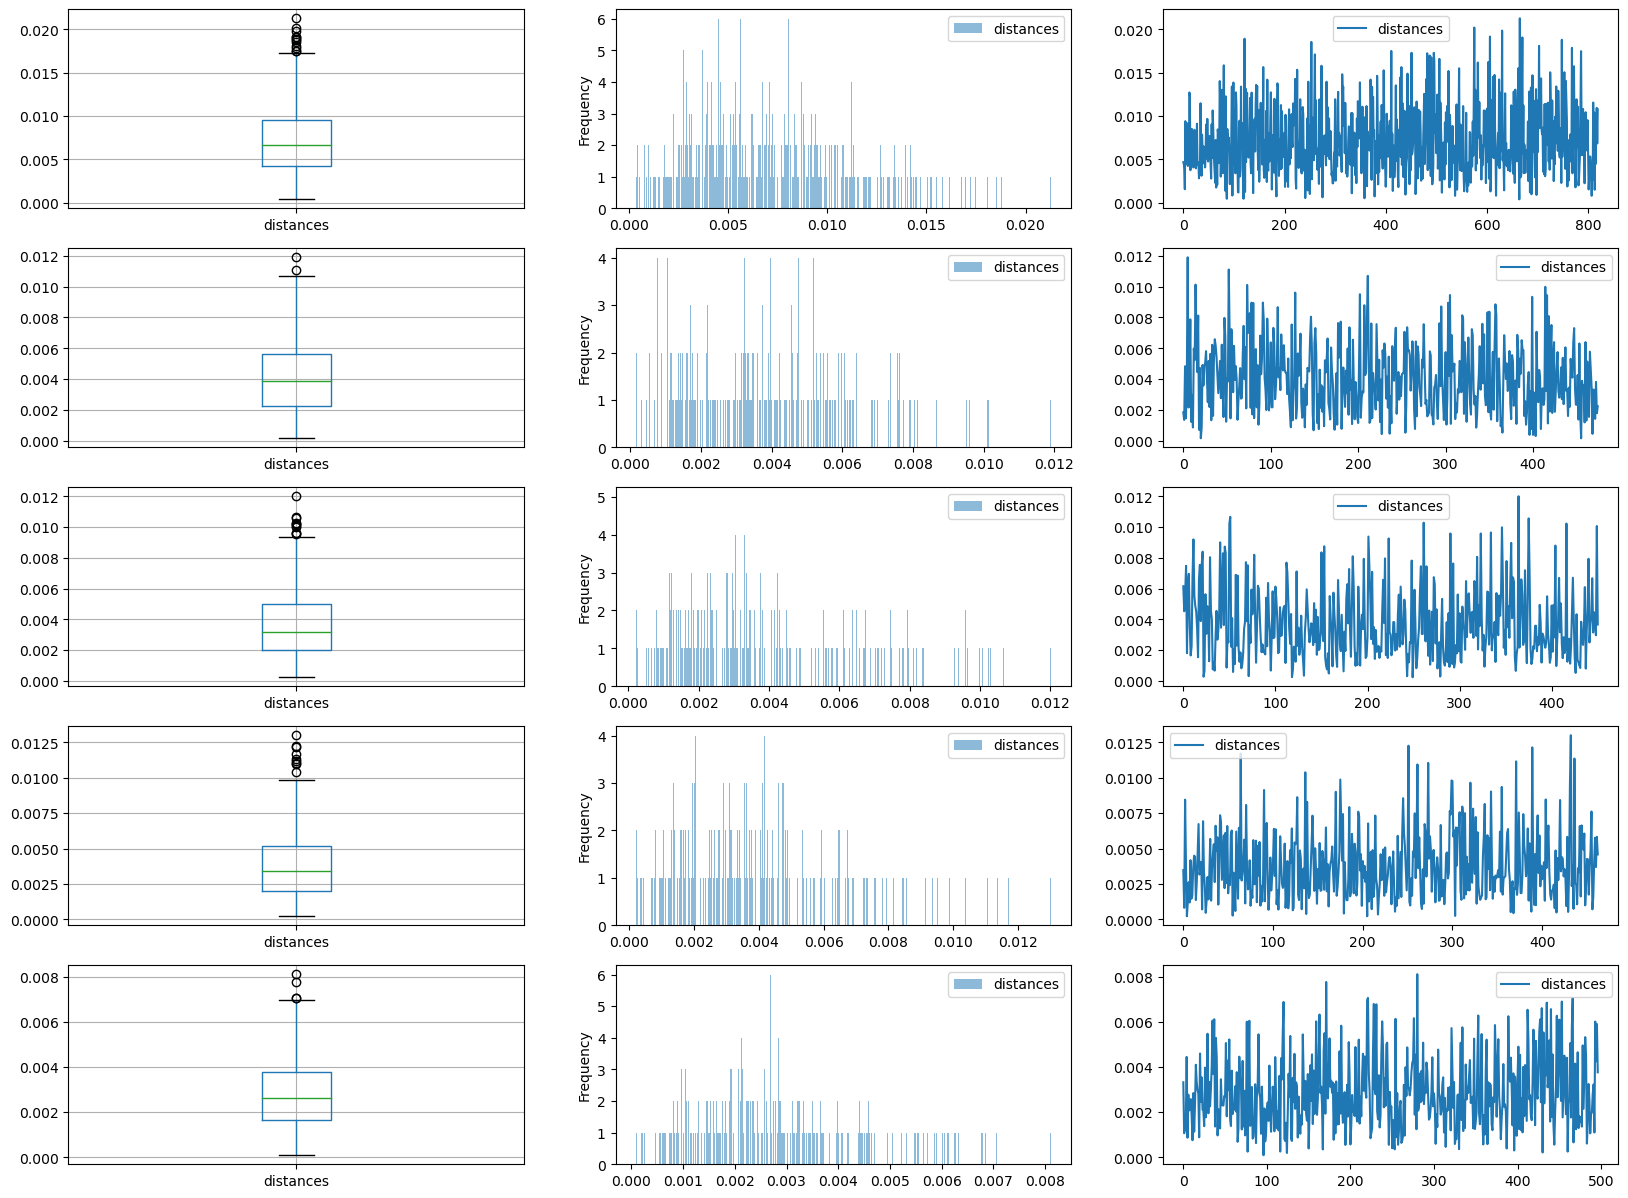

In [9]:
compare_to_average("male", 3849529)

['liver_mesh.ply', 'spleen_mesh.ply', 'left_kidney_mesh.ply', 'right_kidney_mesh.ply', 'pancreas_mesh.ply']


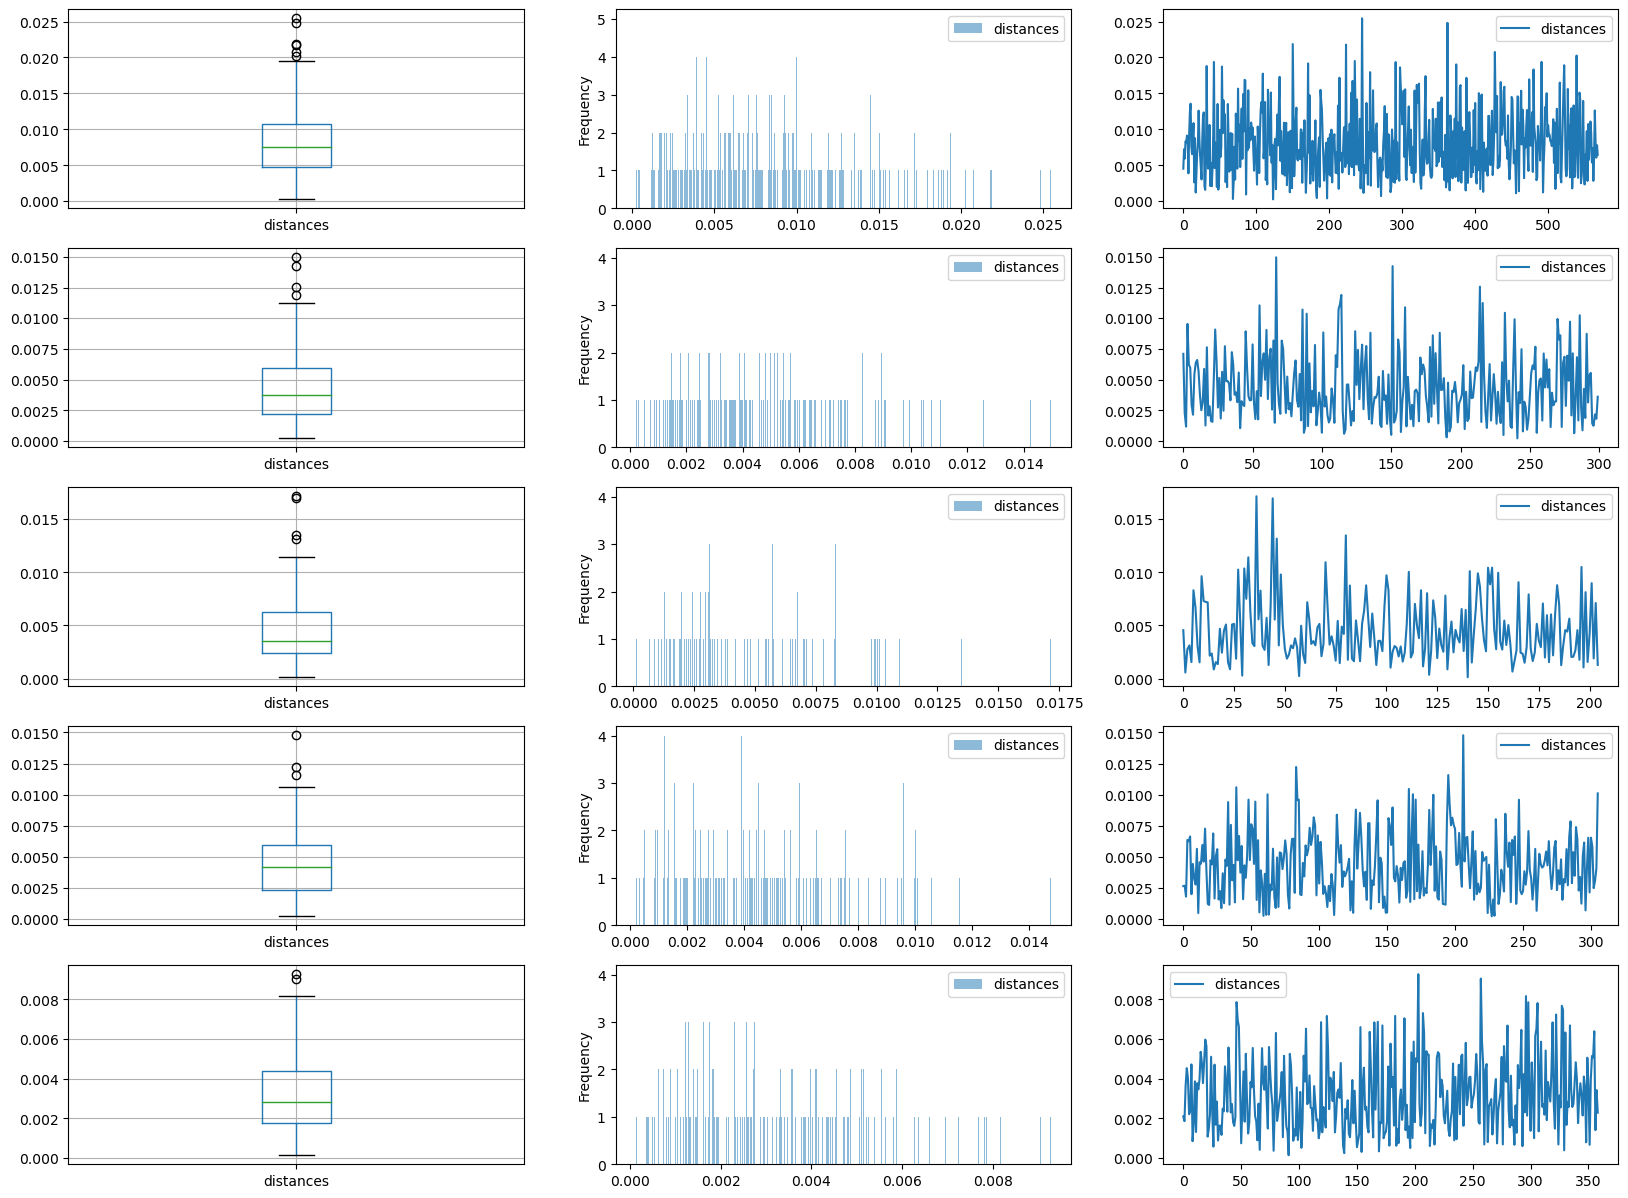

In [284]:
compare_to_average("male", 3849529, manual = True)

# Tests

## Random

In [ ]:
from scipy.linalg import orthogonal_procrustes

x = io.read_triangle_mesh(os.path.join(trimesh_reg_path, "male", "1000180", organ))
y = io.read_triangle_mesh(os.path.join(trimesh_reg_path, "male", "3849529", organ))

x_points = np.asarray(x.vertices)[0:1000]
y_points = np.asarray(y.vertices)[0:1000]

transformation, sc = orthogonal_procrustes(x_points, y_points)

In [27]:
transformation

array([[ 0.24858639,  0.96628343, -0.0670906 ],
       [ 0.96602864, -0.24227535,  0.08995171],
       [-0.07066445,  0.08717221,  0.99368382]])

In [28]:
x.transform(transformation)
o3d.visualization.draw_geometries([x, y], mesh_show_wireframe=True, mesh_show_back_face=True, window_name="Transformed in Red")

TypeError: transform(): incompatible function arguments. The following argument types are supported:
    1. (self: open3d.cpu.pybind.geometry.Geometry3D, arg0: numpy.ndarray[float64[4, 4]]) -> open3d.cpu.pybind.geometry.Geometry3D

Invoked with: TriangleMesh with 1009 points and 1999 triangles., array([[ 0.24858639,  0.96628343, -0.0670906 ],
       [ 0.96602864, -0.24227535,  0.08995171],
       [-0.07066445,  0.08717221,  0.99368382]])

## PointCloud Library

### Fast triangulation of unordered point clouds

In [3]:
import pclpy
from pclpy import pcl
import os
import numpy as np


for organ in organs:
    # path = os.path.join(manual_average_pcds_path, "tensors", "male", organ).replace("\\","/")
    # path = os.path.join(manual_average_pcds_path, "tensors", "transformation", "male", organ).replace("\\","/")
    path = "./test.ply"
    point_cloud = pcl.PointCloud.PointXYZINormal()
    pcl.io.loadPLYFile(path, point_cloud)
    
    
    mesh = pcl.PolygonMesh()
    mls = pcl.surface.GreedyProjectionTriangulation.PointXYZINormal()
    tree = pcl.search.KdTree.PointXYZINormal()
    mls.setSearchRadius(0.3)
    mls.setMu (2.5)
    mls.setMaximumNearestNeighbors (100)
    # mls.setMaximumSurfaceAngle(np.pi / 4) # 45 degrees 
    # mls.setMinimumAngle(np.pi / 18) # 10 degrees 
    # mls.setMaximumAngle(2 * np.pi / 3) # 120 degrees
    mls.setInputCloud(point_cloud)
    mls.setSearchMethod(tree)
    mls.reconstruct(mesh)
    
    # pcl.io.save(os.path.join(manual_average_meshes_path, "pcl", "male", organ), mesh)
    # pcl.io.save(os.path.join(manual_average_meshes_path, "pcl", "transformation", "male", organ), mesh)
    pcl.io.save("./mesh_test.ply", mesh)
    break
    # print(point_cloud.xyz)
    # print(mesh.polygons)

In [5]:
for organ in organs:
    source = io.read_triangle_mesh(os.path.join(manual_average_meshes_path, "pcl", "male", organ)) #by avg pts
    # target = io.read_triangle_mesh(os.path.join(manual_median_meshes_path, "male", organ)) #by avg pts
    target = io.read_triangle_mesh("./mesh_test.ply") #by avg pts

    print(target)
    # source = io.read_triangle_mesh(os.path.join(manual_average_meshes_path, "pcl", "transformation", "male", organ)) 
    # target = io.read_triangle_mesh(os.path.join(manual_average_meshes_path, "transformation", "male", organ))
    compare_results(source, target, (0.5, 0, 0))
    break

TriangleMesh with 20738 points and 2752 triangles.


### Construct a concave or convex hull polygon for a plane model

In [48]:
import pclpy
from pclpy import pcl
import os
import numpy as np
from pclpy.pcl.sample_consensus import SACMODEL_NORMAL_PLANE


for organ in organs:
    path = os.path.join(manual_average_pcds_path, "tensors", "male", organ).replace("\\","/")
    cloud = pcl.PointCloud.PointXYZ()
    pcl.io.loadPLYFile(path, cloud)

    passthrough_filter = pcl.filters.PassThrough.PointXYZ()
    passthrough_filter.setInputCloud(cloud)
    passthrough_filter.setFilterFieldName("z")
    passthrough_filter.setFilterLimits(0.0, 1.0)
    
    # Apply the filter
    cloud_filtered = pcl.PointCloud.PointXYZ()
    passthrough_filter.filter(cloud_filtered)
    
    # seg = cloud_filtered.make_segmenter_normals(ksearch=50)
    seg = pcl.segmentation.SACSegmentation.PointXYZ()
    seg.setInputCloud(cloud_filtered)
    seg.setOptimizeCoefficients(True)
    seg.setModelType(pcl.sample_consensus.SACMODEL_NORMAL_PLANE)
    seg.setMethodType(pcl.sample_consensus.SAC_RANSAC)
    seg.setMaxIterations(100)
    seg.setDistanceThreshold(0.01)
    
    inliers = pcl.PointIndices()
    coefficients = pcl.ModelCoefficients()
    seg.segment(inliers, coefficients)
    
    cloud_projected = pcl.PointCloud.PointXYZ()
    proj = pcl.filters.ProjectInliers.PointXYZ()
    proj.setModelType(pcl.sample_consensus.SACMODEL_PLANE)
    proj.setInputCloud(cloud_filtered)
    proj.setModelCoefficients (coefficients);
    proj.filter(cloud_projected)
    
    
    cloud_hull = pcl.PointCloud.PointXYZ()
    chull = pclpy.pcl.surface.ConcaveHull.PointXYZ()
    chull.setInputCloud(cloud_projected)
    chull.setAlpha(0.1)
    chull.reconstruct(cloud_hull)
    
    if cloud_hull.size != 0:
        pcl.io.save('table_scene_mug_stereo_textured_hull.ply', cloud_hull)
    

### Get better Normals (fail)

In [18]:
import pclpy
from pclpy import pcl
import os
import numpy as np


for organ in organs:
    path = os.path.join(manual_average_pcds_path, "tensors", "male", organ).replace("\\","/")
    point_cloud = pcl.PointCloud.PointXYZ()
    pcl.io.loadPLYFile(path, point_cloud)
    
    
    tree = pcl.search.KdTree.PointXYZ()
    
    mls_points = pcl.PointCloud.PointNormal()
    mls = pcl.surface.MovingLeastSquares.PointXYZ_PointNormal()
    mls.setComputeNormals(True)
    
    mls.setInputCloud(point_cloud)
    mls.setPolynomialOrder(2)
    mls.setSearchMethod(tree)
    mls.setSearchRadius(0.03)
    mls.process(mls_points)
    
    pcl.io.save("test.ply", mls_points)

ModuleNotFoundError: No module named 'pclpy'

In [23]:
# for organ in organs:
source = io.read_point_cloud("text.ply")
target = io.read_point_cloud(os.path.join(manual_average_pcds_path, "tensors/", "male/", "pancreas_mesh.ply"))
compare_results(source, target, (0, 0, 0))

## PyMeshLab

In [28]:
import pymeshlab
ms = pymeshlab.MeshSet()
ms.load_new_mesh(path)

ms.generate_surface_reconstruction_screened_poisson(depth = 9, visiblelayer  = True, preclean = True)
ms.save_current_mesh('mesh.ply')